c:\Users\THANH TUYEN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


c:\Users\THANH TUYEN\AppData\Local\Programs\Python\Python311\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency YS-JAN will be used.
  self._init_dates(dates, freq)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
VAR-NN - MSE: 14.6439, MAE: 3.2058, R²: -6.6620
Hybrid VAR-NN - MSE: 5.2769, MAE: 1.7393, R²: -1.9980
VAR - MSE: 13.3942, MAE: 2.7129, R²: -4.9098


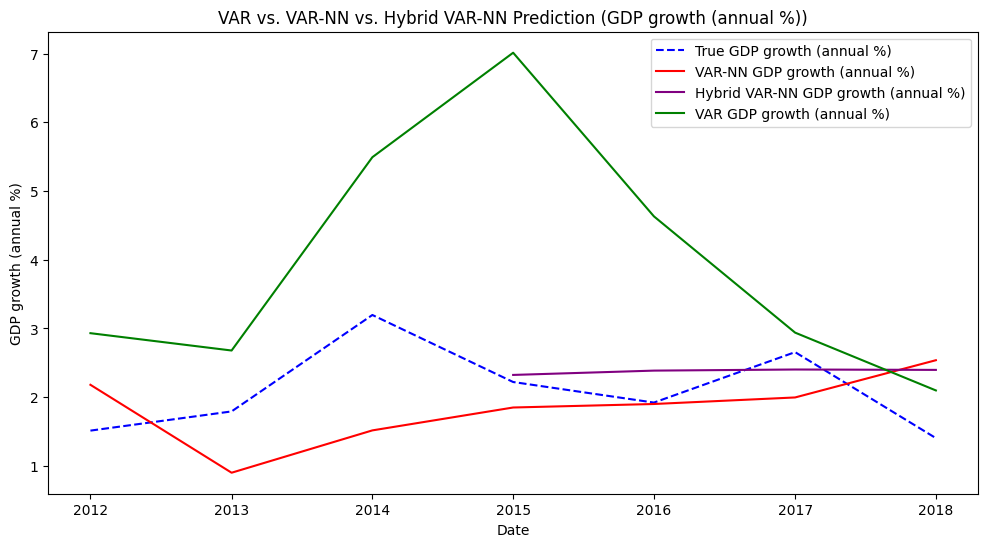

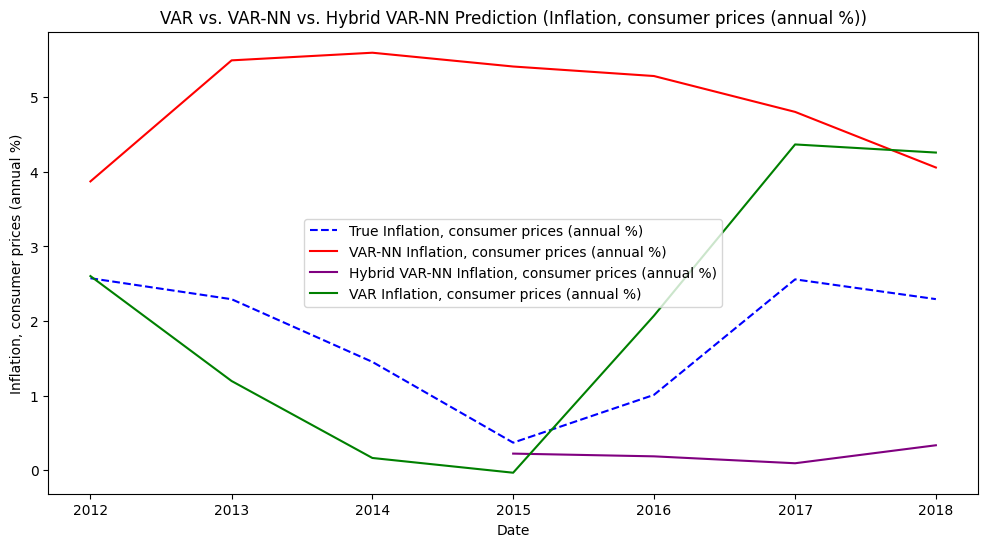

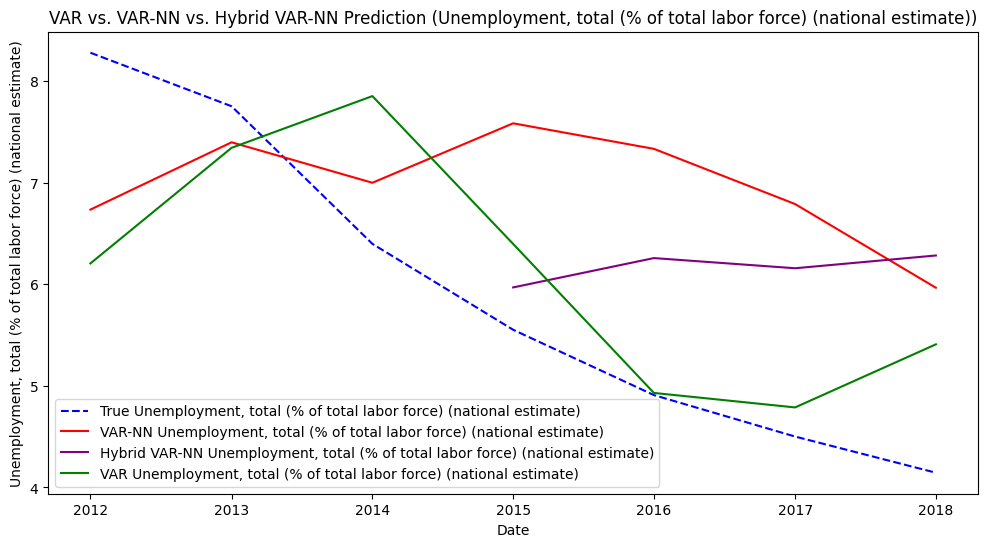

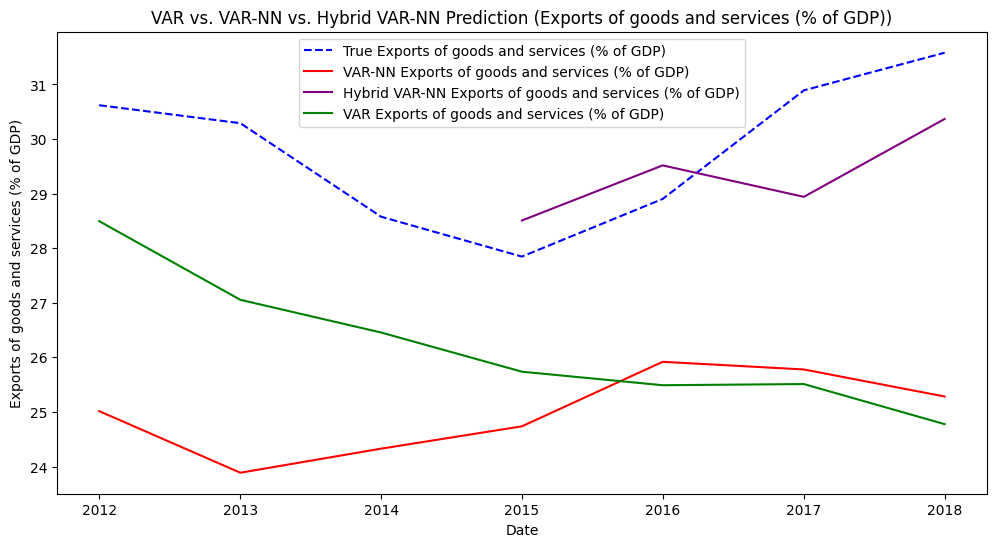

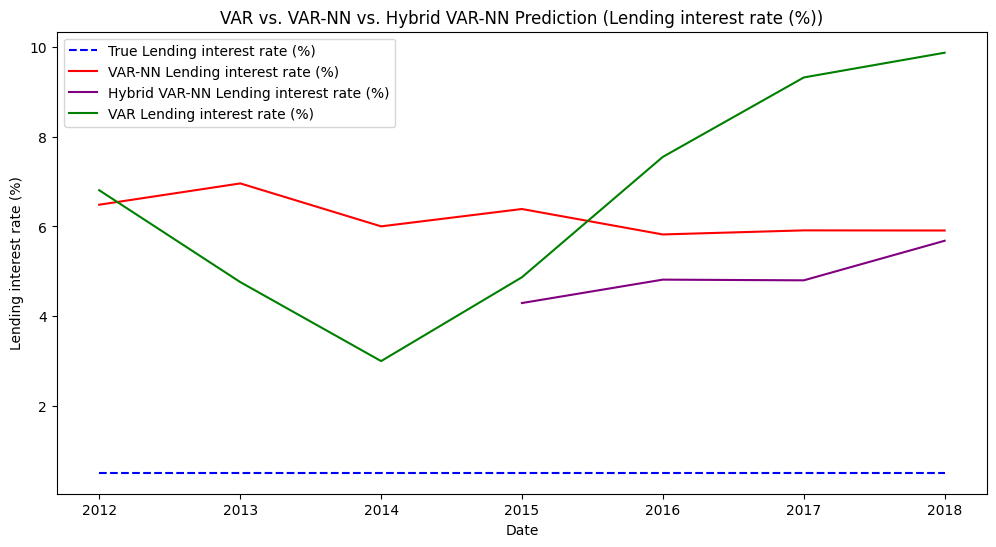

In [7]:
import numpy as np
import pandas as pd
import time
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt

### 1️⃣ Load & Preprocess Data ###
data = pd.read_csv("data/UK_Macro_processed.csv", parse_dates=["Date"], index_col="Date")

# Standardize data
# scaler = StandardScaler()
# data_scaled = pd.DataFrame(scaler.fit_transform(data), columns=data.columns, index=data.index)
data_scaled = data

# Function to create lagged features
def create_lagged_features(df, lags):
    df_lagged = df.copy()
    for lag in range(1, lags + 1):
        lagged = df.shift(lag)
        lagged.columns = [f"{col}_lag{lag}" for col in df.columns]
        df_lagged = pd.concat([df_lagged, lagged], axis=1)
    return df_lagged.dropna()

### 2️⃣ Train-Test-Validation Split ###
def split_data(df, train_ratio=0.7, val_ratio=0.15):
    train_size = int(len(df) * train_ratio)
    val_size = int(len(df) * val_ratio)
    train = df.iloc[:train_size]
    val = df.iloc[train_size:train_size + val_size]
    test = df.iloc[train_size + val_size:]
    return train, val, test

### 3️⃣ Optimize Lag Selection ###
def find_best_lag():
    model_var = VAR(data_scaled)
    var_result = model_var.fit(ic='aic')
    return var_result.k_ar

best_lag = find_best_lag()
data_lagged = create_lagged_features(data_scaled, best_lag)
train, val, test = split_data(data_lagged)

X_train, y_train = train.iloc[:, len(data.columns):], train.iloc[:, :len(data.columns)]
X_val, y_val = val.iloc[:, len(data.columns):], val.iloc[:, :len(data.columns)]
X_test, y_test = test.iloc[:, len(data.columns):], test.iloc[:, :len(data.columns)]

### 4️⃣ Build VAR-NN Model ###
def build_var_nn(input_shape, hidden_units):
    model = Sequential([
        Input(shape=(input_shape,)),
        Dense(hidden_units, activation='relu'),
        Dropout(0.2),
        Dense(len(data.columns), activation='linear')
    ])
    model.compile(optimizer=Adam(learning_rate=0.01), loss='mse', metrics=['mae'])
    return model

# Train & Optimize Hidden Units
def find_best_hidden_units(hidden_units_range):
    best_units, best_mse = None, float("inf")
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, min_delta=0.001)
    
    for hidden_units in hidden_units_range:
        model = build_var_nn(X_train.shape[1], hidden_units)
        model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=0, 
                  validation_data=(X_val, y_val), callbacks=[early_stopping])
        
        y_pred_nn = model.predict(X_val)
        mse_nn = mean_squared_error(y_val, y_pred_nn)
        
        if mse_nn < best_mse:
            best_mse = mse_nn
            best_units = hidden_units
        
    return best_units

best_hidden_units = find_best_hidden_units(range(32, 129, 32))
var_nn = build_var_nn(X_train.shape[1], best_hidden_units)
var_nn.fit(X_train, y_train, epochs=100, batch_size=16, validation_data=(X_val, y_val), verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

### 5️⃣ Implement Hybrid VAR-NN ###
def create_var_predictions(data, model, lag_order, features):
    lagged_data = []
    for i in range(lag_order, len(data)):
        pred = model.forecast(data[features].values[i-lag_order:i], steps=1)
        lagged_data.append(pred[0])
    return np.array(lagged_data)

var_model = VAR(train.iloc[:, :len(data.columns)])
var_result = var_model.fit(ic='aic')
best_lags = var_result.k_ar

train_var_pred = create_var_predictions(train, var_result, best_lags, data.columns)
val_var_pred = create_var_predictions(val, var_result, best_lags, data.columns)
test_var_pred = create_var_predictions(test, var_result, best_lags, data.columns)

y_train_hybrid = y_train.iloc[best_lags:]
y_val_hybrid = y_val.iloc[best_lags:]
y_test_hybrid = y_test.iloc[best_lags:]

hybrid_varnn = build_var_nn(train_var_pred.shape[1], best_hidden_units)
hybrid_varnn.fit(train_var_pred, y_train_hybrid.values, epochs=100, batch_size=16, validation_data=(val_var_pred, y_val_hybrid.values), verbose=0, callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)])

### 6️⃣ Evaluate All Models ###
y_pred_nn = var_nn.predict(X_test)
y_pred_hybrid = hybrid_varnn.predict(test_var_pred)
y_pred_var = var_result.forecast(train.iloc[:, :len(data.columns)].values[-best_lags:], steps=len(test))

def evaluate_model(y_true, y_pred, model_name):
    mse = mean_squared_error(y_true, y_pred)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    print(f"{model_name} - MSE: {mse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")
    return mse, mae, r2

evaluate_model(y_test, y_pred_nn, "VAR-NN")
evaluate_model(y_test_hybrid, y_pred_hybrid, "Hybrid VAR-NN")
evaluate_model(y_test, y_pred_var, "VAR")

column_names = data.columns.tolist()
for i, column in enumerate(column_names):
    plt.figure(figsize=(12, 6))
    plt.plot(y_test.index, y_test.values[:, i], label=f"True {column}", linestyle='dashed', color='blue')
    plt.plot(y_test.index, y_pred_nn[:, i], label=f"VAR-NN {column}", color='red')
    plt.plot(y_test.index[best_lags:], y_pred_hybrid[:, i], label=f"Hybrid VAR-NN {column}", color='purple')
    plt.plot(y_test.index, y_pred_var[:, i], label=f"VAR {column}", color='green')
    plt.legend()
    plt.title(f"VAR vs. VAR-NN vs. Hybrid VAR-NN Prediction ({column})")
    plt.xlabel("Date")
    plt.ylabel(column)
    plt.show()